# Daily Retreat: Using Sentiment Analysis to<br>Find, Personalize, and Share Positive News from Popular Online Sources
__Aaron Carr, Azucena Faus, and Dave Friesen - ADS-599-01-SU23__

In [1]:
__author__ = 'Aaron Carr, Azucena Faus, Dave Friesen'
__email__ = 'acarr@sandiego.edu, afaus@sandiego.edu, dfriesen@sandiego.edu'
__version__ = '1.0'
__date__ = 'July/August 2023'

## Setup

In [2]:
# Import basic and data access libraries
import numpy as np
import pandas as pd

# Import visualization libraries
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import gaussian_kde

# Import utility libraries
import warnings

In [3]:
# Set basic np, pd, and plt output defaults (keeping this code 'clean')
%run -i 'defaults.py'

In [4]:
warnings.filterwarnings(action='ignore', category=UserWarning, module='bitsandbytes')

## Data Load and Validation

In [5]:
# Instantiate and confirm master dataframe
news_00_df = pd.read_csv('../data/data_preprocessed_w_sw_2023-07-20_13-02-01408354.csv')

# Load pre-processed sentiment
news_05_df = pd.read_csv('../data/news-05.csv')
news_05_df = pd.merge(news_00_df, news_05_df, on='text_id')

# Load pre-processed embeddings as numpy array
#embeddings = np.load('../data/embeddings.npy', allow_pickle=True)
#news_05_df['embeddings'] = list(embeddings)

print(news_05_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36405 entries, 0 to 36404
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   text_id                    36405 non-null  int64  
 1   source_name                36405 non-null  object 
 2   author                     36196 non-null  object 
 3   title                      36405 non-null  object 
 4   url                        36405 non-null  object 
 5   publish_date               36405 non-null  object 
 6   article_text               36405 non-null  object 
 7   content                    36405 non-null  object 
 8   processed_text             36403 non-null  object 
 9   processed_text_split       36405 non-null  object 
 10  num_tokens                 36405 non-null  int64  
 11  sentiment_vader            36405 non-null  object 
 12  sentiment_vader_compound   36405 non-null  float64
 13  sentiment_vader_cat        36405 non-null  obj

## Sentiment Analysis: Model Eval

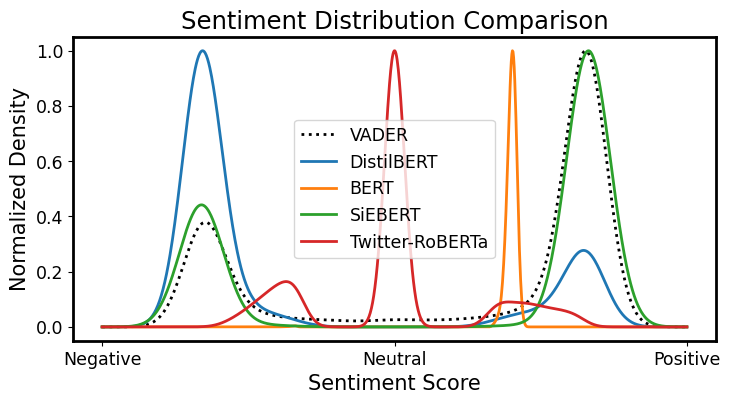

In [6]:
%run -i 'defaults.py'
plt.rcParams['font.size'] *= 1.25
plt.rcParams['axes.labelsize'] *= 1.25
plt.rcParams['axes.titlesize'] *= 1.25
plt.rcParams['xtick.labelsize'] *= 1.25
plt.rcParams['ytick.labelsize'] *= 1.25
plt.rcParams['legend.fontsize'] *= 1.25

# Define dictionary of models with labels
models = {
    'sentiment_vader_compound': 'VADER',
    'sentiment_distilbert': 'DistilBERT',
    'sentiment_bert': 'BERT',
    'sentiment_roberta': 'SiEBERT',
    'sentiment_roberta_m': 'Twitter-RoBERTa'
}

# Define plot boundaries
min_sentiment = news_05_df['sentiment_roberta'].min() - 0.5
max_sentiment = news_05_df['sentiment_roberta'].max() + 0.5

# Generate plot for each model
for model, label in models.items():
    # Compute KDE for model
    model_kde = gaussian_kde(news_05_df[model])
    x_model = np.linspace(min_sentiment, max_sentiment, 1000)
    y_model = model_kde(x_model)

    # Normalize distribution to max value
    y_model /= y_model.max()

    # Plot 'em
    if model == 'sentiment_vader_compound':
        plt.plot(x_model, y_model, linestyle='dotted', color='black', label=label)
    else:
        plt.plot(x_model, y_model, label=label)

# Set custom ticks and labels
ticks = [min_sentiment, 0, max_sentiment]
labels = ['Negative', 'Neutral', 'Positive']
plt.xticks(ticks, labels)

plt.title('Sentiment Distribution Comparison')
plt.xlabel('Sentiment Score')
plt.ylabel('Normalized Density')

plt.legend()
plt.tight_layout()
plt.show()

In [7]:
news_05_df[:10][['title', 'sentiment_roberta_cat'] + list(models.keys())]

,title,sentiment_roberta_cat,sentiment_vader_compound,sentiment_distilbert,sentiment_bert,sentiment_roberta,sentiment_roberta_m
0,"Tito's launches 'Tito's in a Big Can,' an empty cocktail keg listed at $200",positive,0.87,-0.99,0.61,1.00,0.00
1,Search for missing actor Julian Sands continues in 'limited capacity',positive,0.98,0.98,0.60,1.00,0.00
2,Four star running back picks Michigan State over UNC,positive,0.99,-0.99,0.56,1.00,0.00
3,Alabama center Charles Bediako signs one-year deal with San Antonio Spurs,positive,0.98,0.99,0.62,1.00,0.00
4,Ralph Sampson breaks down iconic Boston Celtics-Houston Rockets fight in 1986 playoffs,positive,0.67,0.91,0.63,1.00,0.00
5,Cowherd: Lakers are delusional for wanting to pay Austin Reaves big bucks,positive,0.99,-0.54,0.61,0.99,0.00
6,Recruiting Roundup: Latest Alabama Football recruiting news,positive,1.00,-0.98,0.58,1.00,0.00
7,Eagles’ 2023 training camp preview: Jalen Hurts joins an elite tier of NFL quarterbacks,positive,0.59,-0.69,0.62,1.00,0.00
8,Lincoln Riley’s late-night emoji tweets equal four USC commits on Tuesday,positive,0.92,-1.00,0.58,1.00,0.00
9,Washington passes California as most expensive state for gas: AAA,negative,0.23,-1.00,0.59,-0.68,0.00


<Figure size 750x421.875 with 0 Axes>

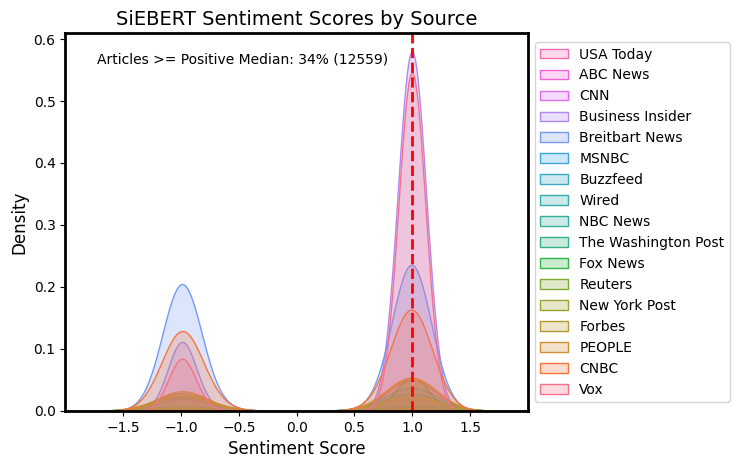

In [8]:
%run -i 'defaults.py'

# Calc articles that fit in the top 50% of positives
median_positive = news_05_df[news_05_df['sentiment_roberta_cat'] ==
                             'positive']['sentiment_roberta'].quantile(0.5)
count_positive = len(news_05_df[(news_05_df['sentiment_roberta_cat'] == 'positive')
                                & (news_05_df['sentiment_roberta'] >= median_positive)])
percentage_positive = (count_positive / len(news_05_df)) * 100

# Plot RoBERTa sentiment distribution, with positive highlights (for web solution+)
plt.figure(figsize=(7.5, 8.5 / (16 / 9)))
sns.kdeplot(data=news_05_df, x='sentiment_roberta', hue='source_name', fill=True)

# Show median line and top article proportion
plt.axvline(median_positive, color='r', linestyle='--')
plt.text(median_positive-0.3, 0.95,
        'Articles >= Positive Median: {:.0f}% ({})'.format(percentage_positive, count_positive),
         horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

# . . . and complete chart
plt.xlim(min_sentiment - 0.5, max_sentiment + 0.5)

plt.title('SiEBERT Sentiment Scores by Source')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')

plt.legend(labels=news_05_df['source_name'].unique(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()